# Assignment 1 - Particle filter

- **Topic:** Designing a particle filter to estimate the position using magnetic field information
- **Assessment:** The assignment will go through a pass/fail check.


- **Deadline:**  28-02-2025, 17:00
- **Submitting: SUBMIT ONLY `assignment1_groupNumber.ipynb` TO BRIGHTSPACE**. 
where groupNumber is your groupnumber


## Instructions
**Installation:** The implementation is tested with python 3.9.12 and packages including
-   numpy version: 1.26.4
-   scipy version: 1.13.0
-   matplotlib version: 3.5.1


Other (not too old or new) versions will probably also work.

You may not use other packages for algorithm-related calculations.
You only need to complete (and submit) this file.
Please do not change the additional files `GP.py`, `helper.py` and `linAlg.py` and the dictionary `modelParameters` as this might result in breaking the assignment.



## AI Related Policy
We strongly discourage you to use AI tools for implementation assistance. It is your understanding of the problem that is tested in the final exam.


## Information
Please fill in your group number, names and student numbers in the cell below.



In [62]:
''' YOUR ANSWER HERE '''
groupNumber = 17

STUDENT_1_NAME = "Tom Lijding"
STUDENT_1_STUDENT_NUMBER = "6318037"

STUDENT_2_NAME = "Tjalle Aalbers"
STUDENT_2_STUDENT_NUMBER = "5374774"

# raise NotImplementedError()

## Objectives

#### Goal

The goal of this assignment is to estimate the position $ \mathbf{p}_t $ of an agent. The agent moves in an indoor environment and gets information about its approximate change in position $ \Delta \mathbf{p}_t $ at every time-step. To model this, you may assume a linear dynamic model of the form:
$$\mathbf{p}_{t + 1} = \mathbf{p}_t + \Delta \mathbf{p}_{t+1} + \mathbf{w}_{t+1}$$

Where:

- $\mathbf{p}_t$ is a 3-dimensional position vector of the agent at time $t$. 

- $\Delta \mathbf{p}_t$ is the change in positon.

- $\mathbf{w}_t \sim \mathcal{N}(0_{3 \times 1}, \mathbf{Q})$ is Gaussian white noise.

- $ \mathbf{Q} \in \mathbb{R}^{3 \times 3} $ is the covariance of the process noise.

Since the information of the change in position $ \Delta \mathbf{p}_t$ contains errors, the position estimates from the dynamic model will drift. This means that over time, the agent will lose track of where it actually is. To remedy this, the agent is carrying a magnetometer, and has a map of the magnetic field. The magnetometer samples a measurement of the magnetic field $\mathbf{y}_t$ at every position $\mathbf{p}_t$. The map of the magnetic field is modeled by a non-linear function: a reduced rank Gaussian process (you do not need to understand, model or change the GP model, only to call the function evaluation). This results in the non-linear measurement model:
$$ \mathbf{y}_t = f(\mathbf{p}_t) + \mathbf{v}_t $$

Where:

- $\mathbf{y}_t$ is a 3-dimensional measurement vector of the magnetic field at time-step $t$.

- $f(\cdot)$ is the reduced rank Gaussian process function.

- $\mathbf{v}_t \sim \mathcal{N}(0_{3 \times 1}, \mathbf{R})$ is Gaussian white noise.

- $ \mathbf{R} \in \mathbb{R}^{3 \times 3} $ is the covariance of the measurement noise.


#### First load in the data
To start, first load in the data below
All variables you will use are numpy arrays, where
- `magnetometerMeasurements` $\in \mathbb{R}^{3 \times N}$ is a numpy array containing the magnetometer measurements
- `magnetometerInitialPosition` $\in \mathbb{R}^{3 \times 1}$ is a numpy array containing the initial position of the magnetometer
- `deltaMagnetometerPositions` $\in \mathbb{R}^{3 \times N}$ is a numpy array containing the change in position of the magnetometer

#### Warning
- Additionally you are provided with a dictionary modelParameters which is used in creating magnetic field maps. DO NOT CHANGE dictionary as this might break the assignment. To create the particle filter you DO NOT need this dictionary.

In [63]:
''' DO NOT CHANGE THE CODE BELOW '''
import numpy as np
import matplotlib.pyplot as plt

import GP as GP
import linAlg as linAlg
import helper as helper
np.random.seed(groupNumber)

''' load in the data'''
(magnetometerMeasurements, 
 magnetometerInitialPosition, 
 deltaMagnetometerPositions,
 modelParameters) = helper.initializeParticleFilterAssignment(groupNumber % 29)

print(modelParameters['NtimeSteps'])

712


Below, a function is given to plot the map of the magnetic field and the ground truth position of the path taken by the agent. The agent does not know this path, it only has access to its initial position, the change in position at every time-step and the magnetometer measurements. 

Your first task it to use the agent's dynamic model to try and reconstruct the ground truth path. This is also known as dead reckoning and should be done using data stored in the variables `magnetometerInitialPosition` and `deltaMagnetometerPositions`. Save the agent's positions according to the dynamic model in the variable `deadReckoning` $\in \mathbb{R}^{3 \times N}$. Additionally, compare the magnetometer measurements with the map of the magnetic field. To achieve this, store the norm of the magnetic field at every time-step in the variable `magneticFieldNorm` $\in \mathbb{R}^{N}$.

This function should output three subfigures. Every subfigure includes the magnetic field map in the background. On the left the ground truth positions are plotted together with the dead reckoning positions. In the middle the magnetic field measurements are plotted with  the ground truth positions on top of the magnetic field map. On the right, the magnetic field measurements are plotted with  the ground truth positions over the magnetic field map.

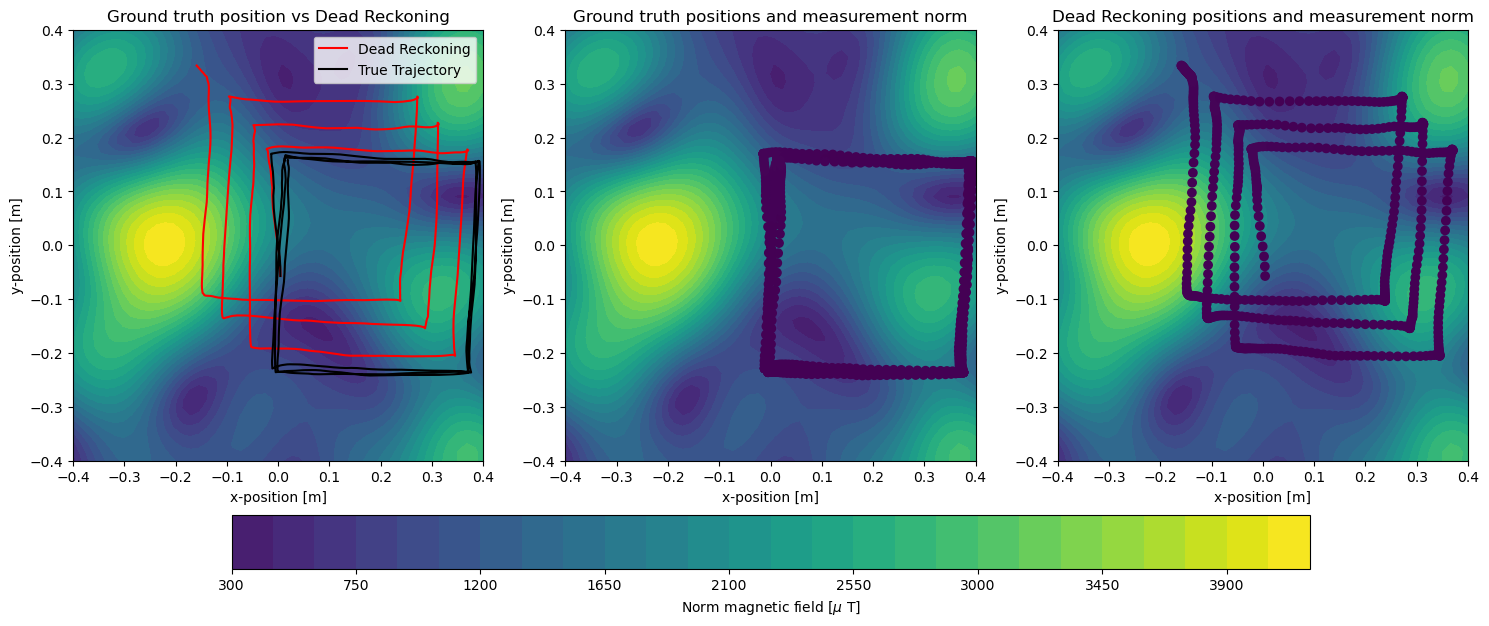

In [64]:
deadReckoning = np.zeros_like(deltaMagnetometerPositions)
deadReckoning[:, 0] = magnetometerInitialPosition.flatten() 

# Compute dead reckoning path
for t in range(1, deltaMagnetometerPositions.shape[1]):
    deadReckoning[:, t] = deadReckoning[:, t-1] + deltaMagnetometerPositions[:, t]
magneticFieldNorm = np.linalg.norm(magnetometerMeasurements, axis=0)

helper.makeInitialPositionPlots(deadReckoning, magneticFieldNorm, modelParameters)


### Discuss

Comment below on the three plots. 
- 	Does the dynamic model provide accurate enough information about the agent’s position? What will happen to the position of the agent if it moves for longer periods of time?
- Based on the magnetic field map shown in the background, explain why or why not the magnetic field is a good source of information for position estimation. 
- Explain why the measurements do or do not agree with the magnetic field map (for the middle and the right plots).


### Particle Filter Implementation

One way to reduce the positional drift observed in the figure above, is to use magnetometer measurements. To this end, you will design a particle filter. Your task is to fill in the following three functions.

#### Task
Fill in the `dynamicUpdate()` function according to the dynamic model given above. 

#### Note:
You do not have to change the inputs and outputs to the given functions.


In [65]:

def dynamicUpdate(particlePositions, 
                  deltaPosition,
                  processCovariance,
                  Nparticles):
    
     # Generate process noise from a multivariate normal distribution
    processNoise = np.random.multivariate_normal(mean=np.zeros(3), cov=processCovariance, size=Nparticles).T
    
    # Update each particle position
    for i in range(Nparticles):
        particlePositions[:,i] = particlePositions[:,i] + deltaPosition + processNoise[:,i]

    return particlePositions

#### Discuss

Comment on the role of the function of the dynamicUpdate in the particle filter

#### Task

Fill in the `measurementUpdate()` according to the measurement model given above. 

To implement the measurement model, you will need to make predictions of the magnetic field. You DO NOT need to create this function yourself. To make predictions, use the function `GP.makeMagneticFieldPrediction(positions, modelParameters)` function make sure the input `positions` $\in \mathbb{R}^{3 \times N} $. The output should be a matrix $\in \mathbb{R}^{3 \times N}$ magnetic field predictions for every input location.

In [66]:
import numpy as np
from scipy.stats import multivariate_normal

def measurementUpdate(particlePositions, 
                      particleWeights,
                      magnetometerMeasurement,
                      measurementCovariance,
                      Nparticles,
                      modelParameters):
    
    ''' Measurement update for the particle filter '''
    predictionsMagneticFieldParticles = GP.makeMagneticFieldPrediction(particlePositions, modelParameters)  
    likelihoods = np.zeros(Nparticles)
    
    for i in range(Nparticles):
        likelihoods[i] = multivariate_normal.pdf(magnetometerMeasurement, mean = predictionsMagneticFieldParticles[:,i], cov = measurementCovariance)

    particleWeights *= likelihoods 

    particleWeights /= np.sum(particleWeights)

    return particlePositions, particleWeights

#### Discuss
Comment on the role of the function of the measurementUpdate in the particle filter

#### Task

Fill in the remainder of the `particleFilter()` function. 


In [ ]:
def particleFilter(particlePositions, 
                   deltaPosition, 
                   magnetometerMeasurement, 
                   processCovariance, 
                   measurementCovariance, 
                   Nparticles,
                   modelParameters):
    ''' Estimates position based on a known map'''

    particleWeights = 1/Nparticles

    if modelParameters['NtimeStepPF'] > 0:
        ''' Dynamic update '''
        particlePositions = dynamicUpdate(particlePositions, 
                                          deltaPosition, 
                                          processCovariance, 
                                          Nparticles)  


    ''' Measurement update '''
    (particlePositions, 
        particleWeights) = measurementUpdate(particlePositions, 
                                             particleWeights,
                                             magnetometerMeasurement, 
                                             measurementCovariance, 
                                             Nparticles,
                                             modelParameters)

    ''' Resampling '''    
    if np.sum(particleWeights) > 1e-12:
        particleWeights /= np.sum(particleWeights)
        indices = helper.systematicResample(particleWeights)
        particlePositions = particlePositions[:, indices]
    else:
        print('Degenerate particles: All the weights are close to zero !!!')
        particleWeights /= np.sum(particleWeights)
        indices = helper.systematicResample(particleWeights)

    meanPosition = np.mean(particlePositions, axis=1)
    maxPositionindex = np.argmax(particleWeights)
    maxPosition = particlePositions[:, maxPositionindex]

    return particlePositions, meanPosition, maxPosition


#### Discuss

Comment on the role of the function of the systematicResample in the particle filter

#### Task 4

Choose a suitable amount of particles, an initial position covariance, a suitable motion covariance and a suitable measurement covariance.

You could start with the following parameters
- `initalPositionCovariance` = np.eye(3)*0
- `Nparticles` = 100
- `processCovariance` = np.eye(3)*0.001**2
- `measurementCovariance` = np.eye(3)*1.5**2

To get better results, you might have to tune these. 

In [69]:
''' Number of particles used in the particle filter '''
Nparticles = 100

''' Inital position covariance of the position '''
initalPositionCovariance = np.eye(3)*1

''' process covariance and measurement covariance '''
processCovariance = np.eye(3)*1*2
measurementCovariance = np.eye(3)*1.5**2
'''Iteration 1: processCovariance = np.eye(3)*0.001*2'''
'''Iteration 2: processCovariance = np.eye(3)*0.01*2'''
'''Iteration 3: processCovariance = np.eye(3)*0.1*2'''
'''Iteration 4: measurementCovariance = np.eye(3)*3**2'''
'''Iteration 5: processCovariance = np.eye(3)*1*2
measurementCovariance = np.eye(3)*9**2'''

''' Initialize particle positions '''
particlePositions = np.random.multivariate_normal(magnetometerInitialPosition.flatten(),initalPositionCovariance,Nparticles)
particlePositions = np.transpose(particlePositions)

''' Create matrices to store mean and best particle position at every time-step'''
meanParticlePosition = np.zeros((3,modelParameters['NtimeSteps']))
bestParticlePosition = np.zeros((3,modelParameters['NtimeSteps']))

''' Initialize and run  the Particle Filter '''
modelParameters['NtimeStepPF'] = 0
for timendx in range(modelParameters['NtimeSteps']-1):
    deltaPosPF = deltaMagnetometerPositions[:,timendx]
    ymeasPF = magnetometerMeasurements[:,timendx]
    (particlePositions, 
     meanParticlePosition[:, timendx+1], 
     bestParticlePosition[:, timendx+1]) = particleFilter(particlePositions, 
                                                        deltaPosPF, 
                                                          ymeasPF, 
                                                          processCovariance, 
                                                          measurementCovariance, 
                                                          Nparticles,
                                                          modelParameters)

    modelParameters['NtimeStepPF'] += 1


C:\Users\tomli\AppData\Local\Temp\ipykernel_18148\3138235190.py:20: RuntimeWarning: invalid value encountered in divide
  particleWeights /= np.sum(particleWeights)


Degenerate particles: All the weights are close to zero !!!
Degenerate particles: All the weights are close to zero !!!
Degenerate particles: All the weights are close to zero !!!
Degenerate particles: All the weights are close to zero !!!
Degenerate particles: All the weights are close to zero !!!
Degenerate particles: All the weights are close to zero !!!
Degenerate particles: All the weights are close to zero !!!
Degenerate particles: All the weights are close to zero !!!
Degenerate particles: All the weights are close to zero !!!
Degenerate particles: All the weights are close to zero !!!
Degenerate particles: All the weights are close to zero !!!
Degenerate particles: All the weights are close to zero !!!
Degenerate particles: All the weights are close to zero !!!
Degenerate particles: All the weights are close to zero !!!
Degenerate particles: All the weights are close to zero !!!
Degenerate particles: All the weights are close to zero !!!
Degenerate particles: All the weights ar

### Visualize the output

In [ ]:
helper.makeParticleFilterPlots(deadReckoning, meanParticlePosition, bestParticlePosition, modelParameters)

#### Discuss

Elaborate on the two plots.
- Does the particle filter improve the position estimates?
- Are the weighted average particle trajectory and the best particle trajectory the same or different? Why is that the case?


#### Task

Play around with different parameters. Comment on what happens if we choose lower or higher values for
- `initalPositionCovariance`?
- `Nparticles`?
- `processCovariance`?
- `measurementCovariance`?

And reason about why this is the case

In [ ]:
''' Number of particles used in the particle filter '''
Nparticles = ""


''' Inital position covariance of the position '''
initalPositionCovariance = ""


''' process covariance and measurement covariance '''
processCovariance = ""
measurementCovariance = ""


''' Initialize particle positions '''
particlePositions = ""


''' Create matrices to store mean and best particle position at every time-step'''
meanParticlePosition = ""
bestParticlePosition = ""


''' Initialize and run the Particle Filter '''
modelParameters['NtimeStepPF'] = 0
for timendx in range(modelParameters['NtimeSteps']-1):
    deltaPosPF = ""
    ymeasPF = ""
    (particlePositions, 
     meanParticlePosition[:, timendx+1], 
     bestParticlePosition[:, timendx+1]) = particleFilter(particlePositions, 
                                                          deltaPosPF, 
                                                          ymeasPF, 
                                                          processCovariance, 
                                                          measurementCovariance, 
                                                          Nparticles,
                                                          modelParameters)

    modelParameters['NtimeStepPF'] += 1


In [ ]:
helper.makeParticleFilterPlots(deadReckoning, meanParticlePosition, bestParticlePosition, modelParameters)

#### Discuss

Comment on the reason for choosing a particle filter for this estimation problem.